### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組

Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    contexts = []
    targets = []
    for i in range(window_size, len(corpus)-window_size):
        target = []
        for window_idx in range(i-window_size, i+window_size+1):
            if window_idx == i:
                contexts.append(corpus[window_idx])
            else:
                target.append(corpus[window_idx])
        targets.append(target)
    
    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([4, 0, 5, 7, 1, 2]),
 array([[6, 0],
        [4, 5],
        [0, 7],
        [5, 1],
        [7, 2],
        [1, 3]]))

In [3]:
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int32),
 array([[[0, 0, 0, 0, 0, 0, 1, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]]], dtype=int32))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H)
        W_out = 0.01 * np.random.randn(H, V)

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for _ in range(window_size*2)]
        
        layers = [self.in_layer] + [self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        loss = sum(self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2))
        
        return loss

    def backward(self, dout=1):
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])        
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [18]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 100

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD(lr=0.3)
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

Epoch: 1, Iteration: 1/2, Loss: 4.159245435372897
Epoch: 2, Iteration: 1/2, Loss: 4.15885126453887
Epoch: 3, Iteration: 1/2, Loss: 4.158826254466884
Epoch: 4, Iteration: 1/2, Loss: 4.158718431738586
Epoch: 5, Iteration: 1/2, Loss: 4.158491673942704
Epoch: 6, Iteration: 1/2, Loss: 4.158322508568119
Epoch: 7, Iteration: 1/2, Loss: 4.158232824394959
Epoch: 8, Iteration: 1/2, Loss: 4.157680383352707
Epoch: 9, Iteration: 1/2, Loss: 4.158088390716691
Epoch: 10, Iteration: 1/2, Loss: 4.156872489204532
Epoch: 11, Iteration: 1/2, Loss: 4.155922139345007
Epoch: 12, Iteration: 1/2, Loss: 4.156574449514702
Epoch: 13, Iteration: 1/2, Loss: 4.154011933190802
Epoch: 14, Iteration: 1/2, Loss: 4.152666426550168
Epoch: 15, Iteration: 1/2, Loss: 4.150577936095785
Epoch: 16, Iteration: 1/2, Loss: 4.147556543995401
Epoch: 17, Iteration: 1/2, Loss: 4.142480758367347
Epoch: 18, Iteration: 1/2, Loss: 4.139637396517363
Epoch: 19, Iteration: 1/2, Loss: 4.1298659691714565
Epoch: 20, Iteration: 1/2, Loss: 4.11115

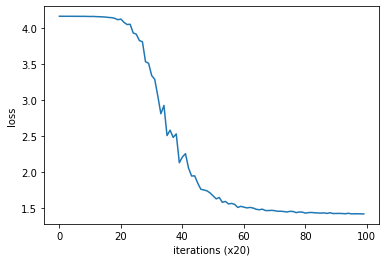

In [19]:
trainer.plot()

In [24]:
for word, idx in word2idx.items():
    print(word, skip_gram.word_vecs[idx])

studying [ 1.23260974  0.6288586   1.75522824  0.83562001 -0.22364321]
processing [ 0.70254596 -1.92419633 -0.12475688 -1.05021316 -0.68081025]
now [-0.38824749  1.34299013 -1.34498135 -1.43941457  0.04434742]
. [ 0.01282212  0.00487877 -0.00443999 -0.00443187 -0.00588578]
am [-1.72722125 -0.15517693 -0.58284009  1.55067952  0.32371988]
natural [-0.34960502 -2.34263191 -0.28577004  1.03851801  0.51915119]
i [ 0.01064592  0.00030154  0.01136268 -0.00623846 -0.00169445]
language [ 1.07057911  1.89610246  0.81814672 -1.28647934  0.1229081 ]
